# Dynamic benchmark v.1.0

## Testing some dynamic variations

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
import matplotlib as mpl
from statistics import mean


# Import custom functions
from utils_benchmark import * 
#test()

sns.set_style("white")

evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"
stats_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/"

#----------------------------------------
#           LOAD INFOS 
#----------------------------------------

# FAMILIES 
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
# AF2
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]


## A reduced dataset for preliminary testing

In [2]:
family_subset = list(["rnasemam", "ghf10", "HMG_box",
                                "egf", "rhv",  "biotin_lipoyl",
                                "adh", "Acetyltransf"])

summary_homfam_exthomfam[(summary_homfam_exthomfam.family.isin(family_subset)) &
                         (summary_homfam_exthomfam.benchmarking_dataset == "homfam")] \
                         [["family", "n_sequences", "size_group"]] \
                         .reset_index(drop = True)

,family,n_sequences,size_group
0,Acetyltransf,46285,xlarge
1,adh,21331,large
2,rhv,17976,large
3,biotin_lipoyl,11833,large
4,egf,7774,medium
5,HMG_box,4779,medium
6,ghf10,1502,small
7,rnasemam,498,small


### Load scores

In [3]:
dataset = "homfam"
scores_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/score/")

scores = pd.DataFrame()
for score_name in os.listdir(scores_dir):
    score_file = os.path.join(scores_dir,score_name)
    
    # only retain the ones in the subset 
    if score_file.endswith(".scores"):
        score_df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
        scores = pd.concat([scores,score_df], ignore_index=True)
scores = scores.drop([5,6,7], axis = 1)

### Load the bucket sizes 

In [4]:
# Extract from .score files 
dataset = "homfam"
alignments_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"alignments/")
buckets_summary = pd.DataFrame()
for root, dirs, files in os.walk(alignments_dir):
    for name in files:
        # Only retain subset 
        file = os.path.join(root,name)
        if file.endswith("bucket.log"):
            name = os.path.basename(os.path.dirname(file))
            if name.startswith("hormone"):
                print(name)
            buckets = list(pd.read_csv(file, header = None, engine='python', delim_whitespace=True)[3])
            less_50 = sum(i <= 50 for i in buckets)
            more_50 = sum(i > 50 for i in buckets)
            less_100 = sum(i <= 100 for i in buckets)
            more_100 = sum(i > 100 for i in buckets)
            mean_buckets = mean(buckets)
            tot = less_50 + more_50
            buckets_df = pd.DataFrame(data = {"name" : [name], "buckets" : [buckets], 
                                             "less_50":less_50, "more_50":more_50, 
                                             "less_100": less_100, "more_100": more_100, "mean_buckets": mean_buckets, 
                                              "tot": tot})
            buckets_df = buckets_df.astype("object")
            buckets_summary = pd.concat([buckets_summary,buckets_df], ignore_index=True)

hormone_rec.regressive.50.FAMSA.FAMSA-medoid
hormone_rec.dynamic.50.dynamicX.100000000.tcoffee_msa.famsa_msa.FAMSA-medoid
hormone_rec.regressive.50.FAMSA.MBED
hormone_rec.dynamic.50.dynamicX.100000000.tcoffee_msa.famsa_msa.MBED


### Load the scores (TC, SP, Column)

In [5]:
import warnings
warnings.filterwarnings("ignore")
scores.columns = ['name', 'sp', 'tc', 'column']
# -------------------------
#      Regressive
# -------------------------
regressive_scores = scores[scores.name.str.contains("regressive")]
regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
regressive_scores["benchmarking_dataset"] = "homfam"

# -------------------------
#      Progressive
# -------------------------
progressive_scores = scores[scores.name.str.contains("progressive")]
progressive_scores[["family", "method", "align_method", "tree_method"]] = progressive_scores.name.str.split(".", expand = True)
progressive_scores["benchmarking_dataset"] = "homfam"

# -------------------------
#      Dyanmic
# -------------------------
dynamic_scores = scores[scores.name.str.contains("dynamic")]
dynamic_scores[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val","master_msa", "slave_msa", "tree_method"]] = dynamic_scores.name.str.split(".", expand = True)

### The subset I am working with: dynamic

In [6]:
# In this analysis I am not interested in the effect of DynamicX.
# I therefore fix it at 100000000.
dynamic_scores = dynamic_scores[dynamic_scores.dynamicX_val == "100000000" ]

# Also fix bucket size at 50 
dynamic_scores = dynamic_scores[dynamic_scores.bucket_size == "50" ]

# I will also now not use the reference values 
# To keep it simple at the beginning
dynamic_scores = dynamic_scores[dynamic_scores.family.str.contains("ref") == False]
dynamic_scores = dynamic_scores[dynamic_scores.master_msa == "tcoffee_msa"]
dynamic_scores["benchmarking_dataset"] = "homfam"

# Prep dataset 
stats_dynamic = pd.merge(dynamic_scores, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stats_dynamic.head(2)

# add buckets
stats_dynamic = pd.merge(stats_dynamic,buckets_summary, how = "left", on = "name")

# Retain the families for which i have all the calculations
stats_dynamic.head(1)


regressive_scores = regressive_scores[regressive_scores.bucket_size == "50" ]

scores_df = pd.concat([regressive_scores, progressive_scores, dynamic_scores], ignore_index=True, sort=False)
scores_df = pd.merge(scores_df, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
scores_df = pd.merge(scores_df,buckets_summary, how = "outer", on = "name")
scores_df = scores_df[scores_df.family.str.contains("ref") == False]

In [7]:
scores_df.to_csv(os.path.join(stats_dir, "03_scores_df.csv"), index = False)

### Regressive and FAMSA on our test dataset
#### To have a reference

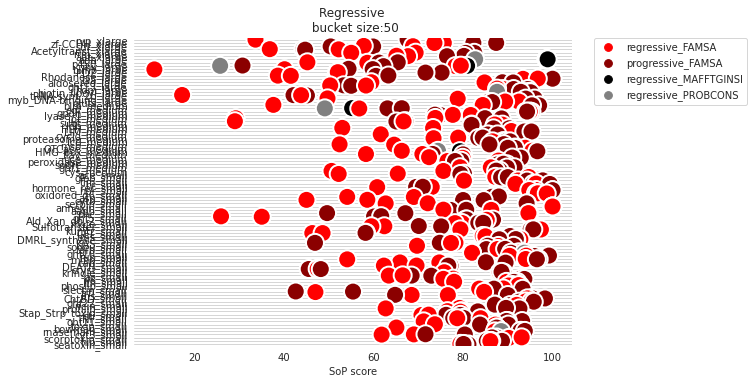

In [8]:
# Just a preliminary check on the regressive performance 
import warnings
warnings.filterwarnings("ignore")


colors = ["red", "darkred", "black", "grey"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))


df = scores_df[scores_df.method.isin(list(["regressive", "progressive"]))]
df["method_extended"] = df.method.astype(str)+"_"+df.align_method.astype(str)
df["fam_extended"] = df.family.astype(str)+"_"+df.size_group.astype(str)

g = sns.PairGrid(df.sort_values("n_sequences", ascending=False), hue = "method_extended",
                 x_vars="sp", y_vars=["fam_extended"],
                 height=5, aspect=1.4)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=18, orient="h", jitter=True,
      palette=colors, linewidth=2, edgecolor="w")

for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set(xlabel=  "SoP score", ylabel='', title = "Regressive \n bucket size:50")
    
sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);



Best performers are Mafft-ginsi (for smaller families) and FAMSA progressive(for bigger ones)

### 1. Does the bucket size influence how well regressive performs? Or how well each method should perform? 
### I compare progressive famsa - regressive famsa and see if the size of the buckets influences this difference 

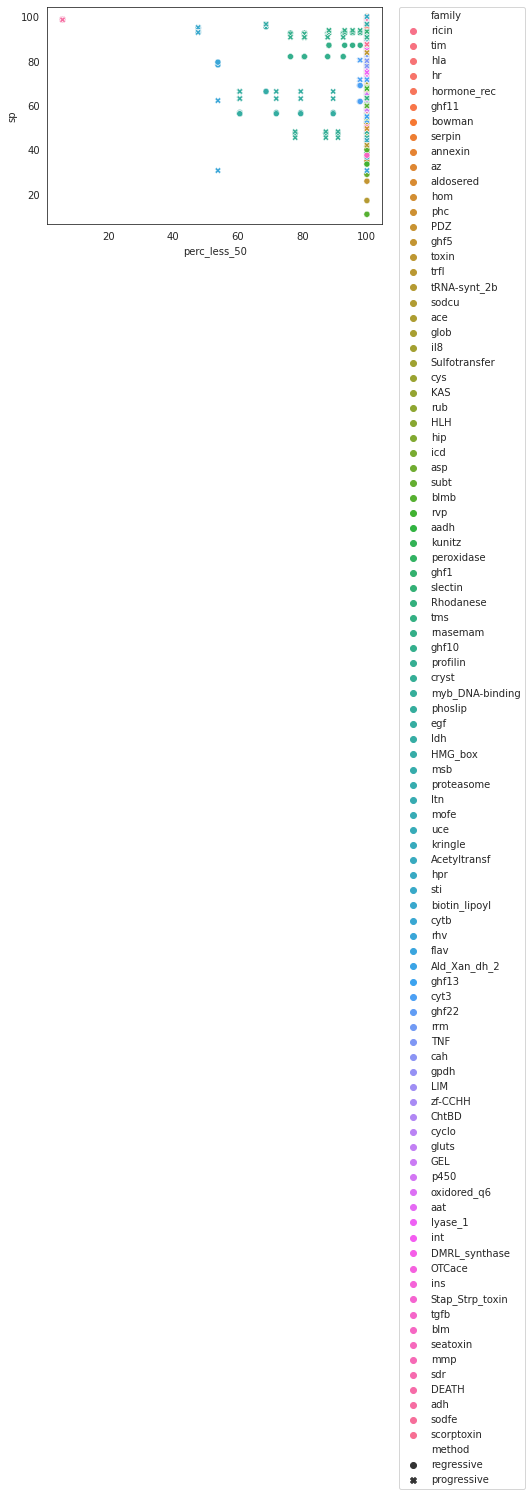

In [110]:
scores_df_famsa = pd.concat([regressive_scores, progressive_scores], ignore_index=True, sort=False)
scores_df_famsa = scores_df_famsa[scores_df_famsa.family.str.contains("ref") == False]
scores_df_famsa = scores_df_famsa[scores_df_famsa.align_method == "FAMSA"]
buckets_summary["family"] = buckets_summary.name.str.split('.', expand = True)[0]
scores_df_famsa = pd.merge(scores_df_famsa,buckets_summary, how = "left", on = "family")
#scores_df_famsa=scores_df_famsa.dropna(subset=['ratio_50'])
scores_df_famsa["perc_less_50"] = scores_df_famsa.less_50*100/scores_df_famsa.tot

sns.scatterplot(data=scores_df_famsa, y="sp", x="perc_less_50", hue="family", style="method")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


As it is not saying anything really, we may need more datapoints. 
Is it something worth exploring large scale? 

## Standard dynamic 
### check slave_msa

In [ ]:
######## TODO --> add here mafft ginsi

In [111]:
metrics = [["sp", "sum of pairs"]]
sns.set_context("talk")

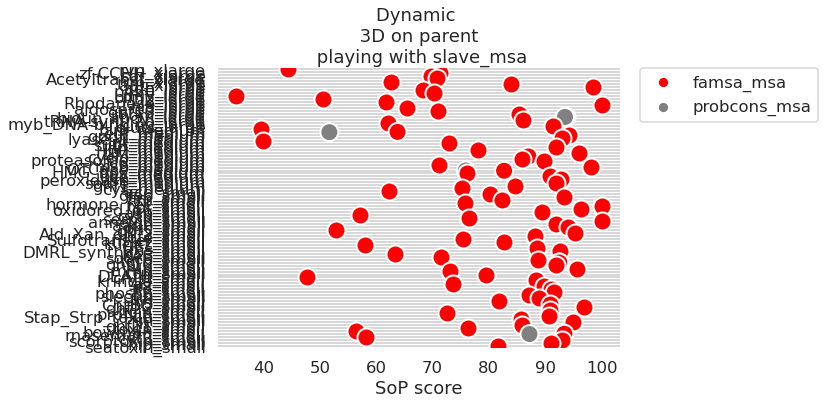

In [112]:
df = stats_dynamic[stats_dynamic.slave_msa.isin(list(["famsa_msa","probcons_msa"]))]
df["fam_extended"] = df.family.astype(str)+"_"+df.size_group.astype(str)

g = sns.PairGrid(df.sort_values("n_sequences", ascending=False), hue = "slave_msa",
                 x_vars="sp", y_vars=["fam_extended"],
                 height=5, aspect=1.4)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=18, orient="h", jitter=True,
      palette=["red", "grey"], linewidth=2, edgecolor="w")

for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set(xlabel=  "SoP score", ylabel='', title = "Dynamic \n 3D on parent \n playing with slave_msa")
    
sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Now i want to explore the effect of the dynamic-dynamic 

Does it have an effect if i change this parameter into something bigger? I try now with 50 and 100 

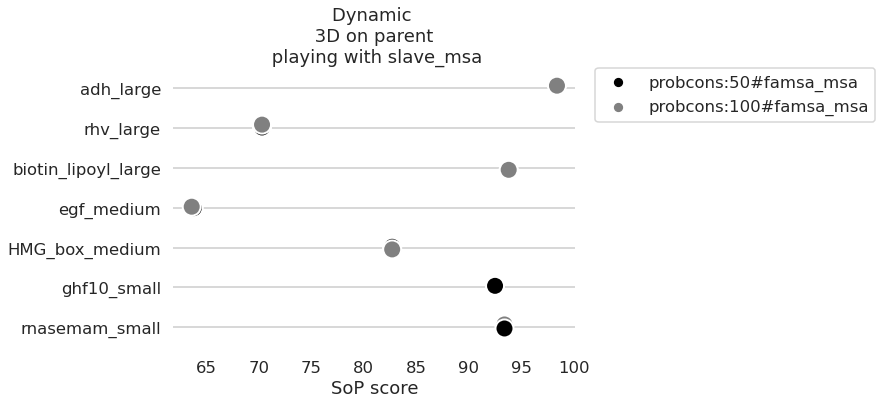

In [113]:
df = stats_dynamic[stats_dynamic.slave_msa.isin(list(["probcons:50#famsa_msa","probcons:100#famsa_msa"]))]
df["fam_extended"] = df.family.astype(str)+"_"+df.size_group.astype(str)

g = sns.PairGrid(df.sort_values("n_sequences", ascending=False), hue = "slave_msa",
                 x_vars="sp", y_vars=["fam_extended"],
                 height=5, aspect=1.4)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=18, orient="h", jitter=True,
      palette=["black", "grey"], linewidth=2, edgecolor="w")

for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set(xlabel=  "SoP score", ylabel='', title = "Dynamic \n 3D on parent \n playing with slave_msa")
    
sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Seems like this does not make a difference, at least with this small numbers. 

# ---------- NOTE: maybe worth repeating it with another MSA? 

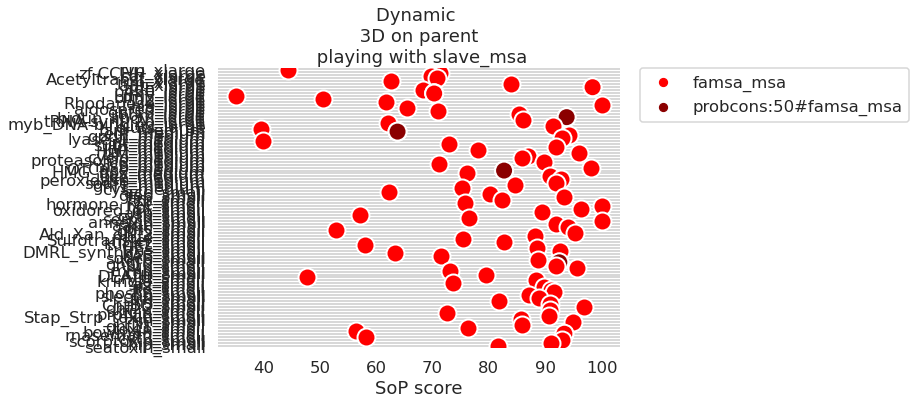

In [114]:
df = stats_dynamic[stats_dynamic.slave_msa.isin(list(["famsa_msa","probcons:50#famsa_msa"]))]
df["fam_extended"] = df.family.astype(str)+"_"+df.size_group.astype(str)

g = sns.PairGrid(df.sort_values("n_sequences", ascending=False), hue = "slave_msa",
                 x_vars="sp", y_vars=["fam_extended"],
                 height=5, aspect=1.4)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=18, orient="h", jitter=True, linewidth=2, edgecolor="w")

for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set(xlabel=  "SoP score", ylabel='', title = "Dynamic \n 3D on parent \n playing with slave_msa")
    
sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

KeyboardInterrupt: 

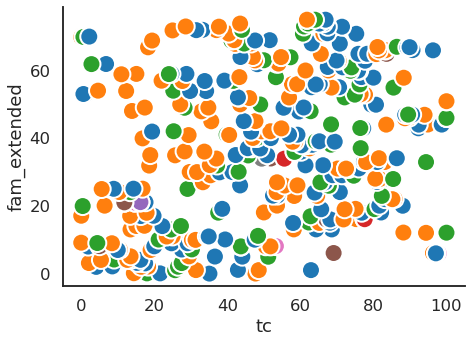

In [115]:
# compare famsa progressive, famsa regressive, famsa dynamic 
df = scores_df
df["approach"] = df[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val", "align_method"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

df["fam_extended"] = df.family.astype(str)+"_"+df.size_group.astype(str)

g = sns.PairGrid(df.sort_values("n_sequences", ascending=False), hue = "approach",
                 x_vars="tc", y_vars=["fam_extended"],
                 height=5, aspect=1.4, palette = "tab10")
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=18, orient="h", jitter=True, linewidth=2, edgecolor="w")

for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set(xlabel=  "SoP score", ylabel='', title = "Dynamic \n 3D on parent \n playing with slave_msa")
    
sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Summary of what we might know better now: 
- probcons suck --> out
- mafft ginsi good --> in 
- the dynamic-dynamic options does not seem to make this much of a difference 
- i may have to test on bigger families ( need to check from before ) 
- then try a different tree

## DyanmicX

NameError: name 'stats_alignments_dynamic' is not defined

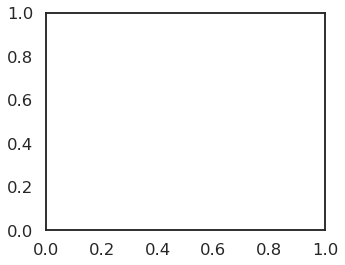

In [116]:
for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="dynamicX_val",
                    palette = "magma")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')

# -------------------------------
#plot_scatter_perc(dyn_1_3d,dyn_1000_3d,'dyn_1_3d', 'dyn_1000_3d', title  = "dynamic on homfam")
#plot_scatter_perc(dyn_1000_3d,dyn_100000000_3d,'dyn_1000_3d', 'dyn_100000000_3d', title  = "dynamic on homfam")
#plot_scatter_perc(dyn_1000_famsa,dyn_1000_3d,'dyn_1000_famsa', 'dyn_1000_3d')

## parent aligner

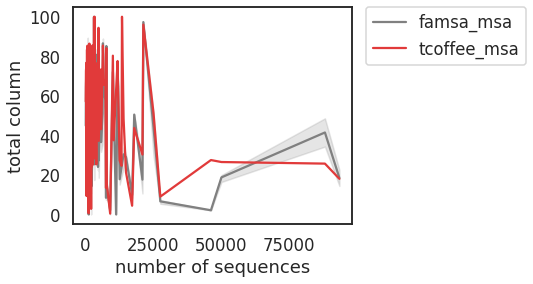

In [155]:
for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="master_msa")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')
    
#plot_scatter_perc(dyn_1_famsa,dyn_1_3d,'dyn_1_famsa', 'dyn_1_3d')
#plot_scatter_perc(dyn_1000_famsa,dyn_1000_3d,'dyn_1000_famsa', 'dyn_1000_3d')

# Regressive

### Which is the bucket size effect? 

In [117]:
stats_alignments_regressive_all = stats_alignments_full[(stats_alignments_full.method == "regressive")]
reg_50_all = stats_alignments_regressive_all[stats_alignments_regressive_all.bucket_size == 50]
reg_1000_all = stats_alignments_regressive_all[stats_alignments_regressive_all.bucket_size == 1000]

NameError: name 'stats_alignments_full' is not defined

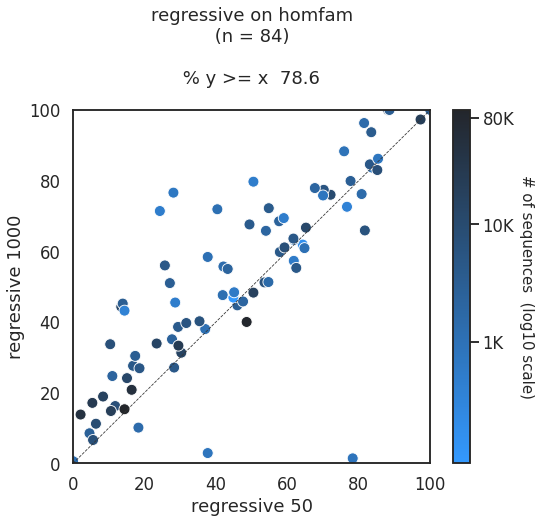

In [157]:
plot_scatter_perc(reg_50_all,reg_1000_all,'regressive 50', 'regressive 1000')

# Compare dynamic vs regressive

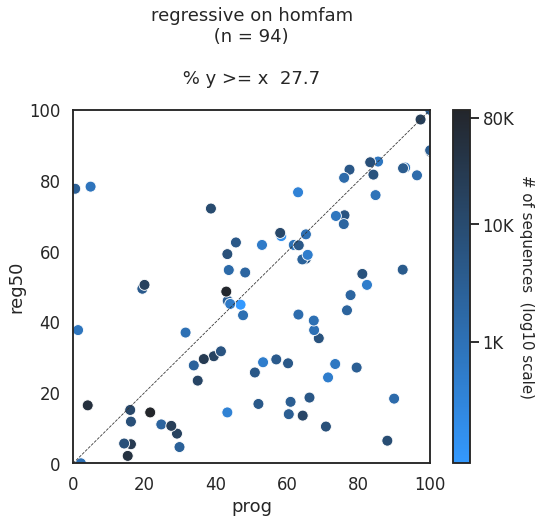

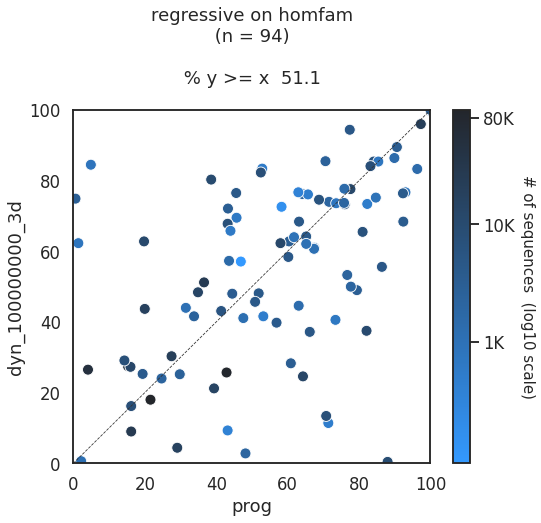

In [158]:
plot_scatter_perc(prog,reg_50,'prog', 'reg50')
#plot_scatter_perc(prog,reg_1000,'prog', 'reg1000')
#plot_scatter_perc(prog,dyn_1_famsa,'prog', 'dyn_1_famsa')
#plot_scatter_perc(prog,dyn_1_3d,'prog', 'dyn_1_3d')
#plot_scatter_perc(prog,dyn_100000000_famsa,'prog', 'dyn_100000000_famsa')
plot_scatter_perc(prog,dyn_100000000_3d,'prog', 'dyn_100000000_3d')

# Cumulative average plot

In [159]:
#df = stats_alignments_full[stats_alignments_full.n_sequences > 1000]
df = stats_alignments_full
df_dyn = df[df.approach == "dynamic_50.0_tcoffee_msa_famsa_msa_100000000"]
fams = (df_dyn.family.unique())

df_prog = df[(df.approach == "progressive") & (df.family.isin(fams))]
df_reg = df[(df.approach == "regressive_50.0")  & (df.family.isin(fams))]
df = pd.concat([df_dyn, df_reg, df_prog])
df.family.unique().shape

df_d_r = pd.merge(df_dyn, df_prog, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y) 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y / abs(df_d_r.sp_y * 100)


df_d_r["Alignment length_x"] = pd.to_numeric(df_d_r["Alignment length_x"])
df_d_r["Average identity_x"] = pd.to_numeric(df_d_r["Average identity_x"].str.replace("%", ""))
df_d_r["Smallest_x"] = pd.to_numeric(df_d_r["Smallest_x"])
df_d_r["Largest_x"] = pd.to_numeric(df_d_r["Largest_x"])
df_d_r["NGAP_x"] = pd.to_numeric(df_d_r["NGAP_x"])


# Which are the ones for which we do not get better? 
family_worst = list(df_d_r[df_d_r.diff_tc < 0].family)
df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.diff_tc < 0, 'diff_qualitatively'] = "worst"
df_d_r.diff_qualitatively.value_counts()

better    48
worst     46
Name: diff_qualitatively, dtype: int64

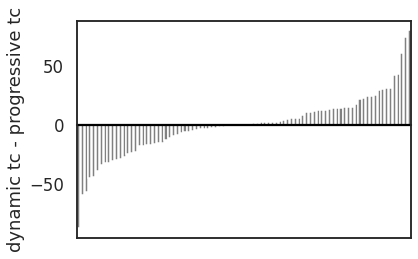

In [160]:
# Center the data to make it diverging
ax = sns.barplot(x=df_d_r.diff_tc, y=df_d_r.diff_tc, color = "grey")
ax.set(xlabel="", ylabel = "dynamic tc - progressive tc", xticklabels="")
ax.axhline(0, color="k", clip_on=False)

<AxesSubplot:xlabel='diff_qualitatively', ylabel='n_sequences_x'>

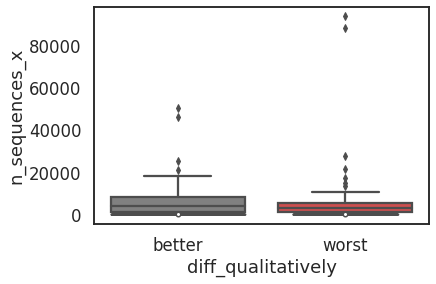

In [161]:
sns.violinplot(data = df_d_r, y = "plddt_mean_x", x = "diff_qualitatively")
sns.boxplot(data = df_d_r, y = "n_sequences_x", x = "diff_qualitatively")

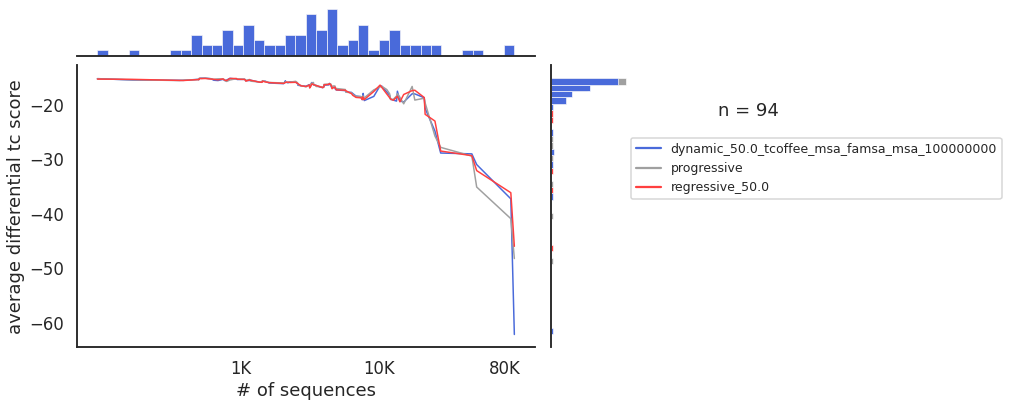

In [162]:
# -------------------------------
#           Plot TC 
# ------------------------------
#df = df[df.n_sequences > 1000]
df["n_sequences_log"] = np.log10( df["n_sequences"] )


x = df.n_sequences_log
y = cumavg(df.sort_values(by=["n_sequences_log"], ascending = False)["diff_tc"])
hue = df["approach"]

colors = [ "#496ADA","#A0A0A0", "#FF3F3F" ]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

ax = sns.JointGrid(x = x, y = y, hue = hue)
ax.plot_joint(sns.lineplot,  linewidth=1.5)
ax.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=40)
ax.ax_joint.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=5.8, fontsize = "x-small")
ax.fig.set_figwidth(10)
ax.fig.set_figheight(6)

ax.ax_joint.set(xlabel = "# of sequences", ylabel = "average differential tc score")
ax.ax_joint.set_xticks(np.log10([1000,10000,80000]))
ax.ax_joint.set_xticklabels(["1K", "10K", "80K"]) 
plt.title("n = "+str(len(fams)), x=2.5, y=0.8)


outdir = "../../../data/structural_regression/plots/03_benchmarkDynamic/" 
plt.savefig(os.path.join(outdir, "01_seq_vs_tc.pdf"))


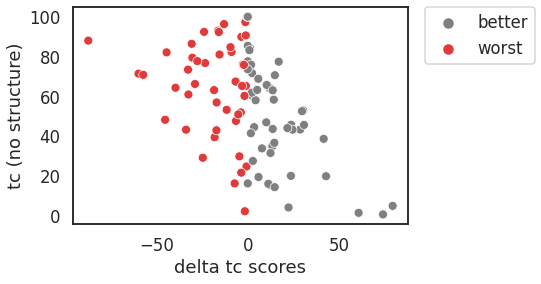

In [163]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "diff_tc", y = "tc_y", hue = "diff_qualitatively").set(ylabel = "tc (no structure)", xlabel = "delta tc scores")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


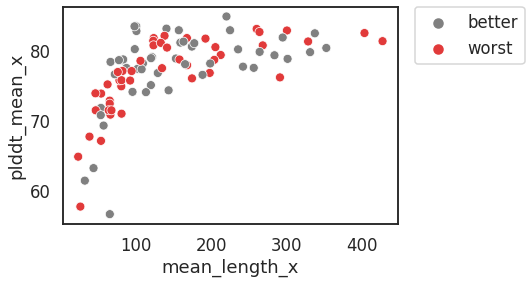

In [164]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "mean_length_x", y = "plddt_mean_x", hue = "diff_qualitatively")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

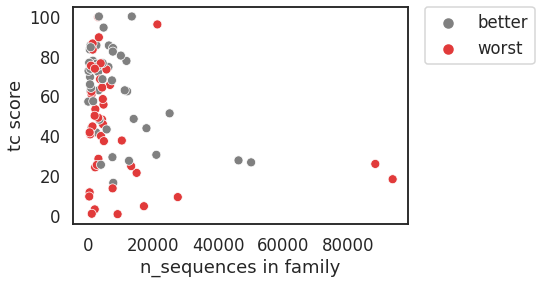

In [165]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, y = "tc_x", x = "n_sequences_x", hue = "diff_qualitatively").set(xlabel  ="n_sequences in family", ylabel = "tc score")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

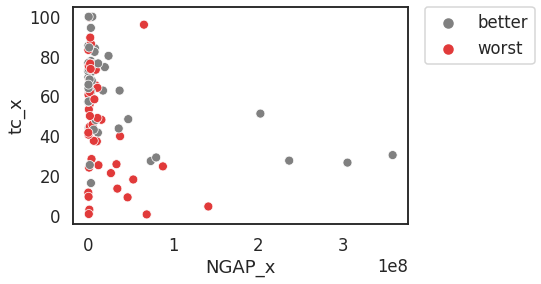

In [166]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, y = "tc_x", x = "NGAP_x", hue = "diff_qualitatively")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

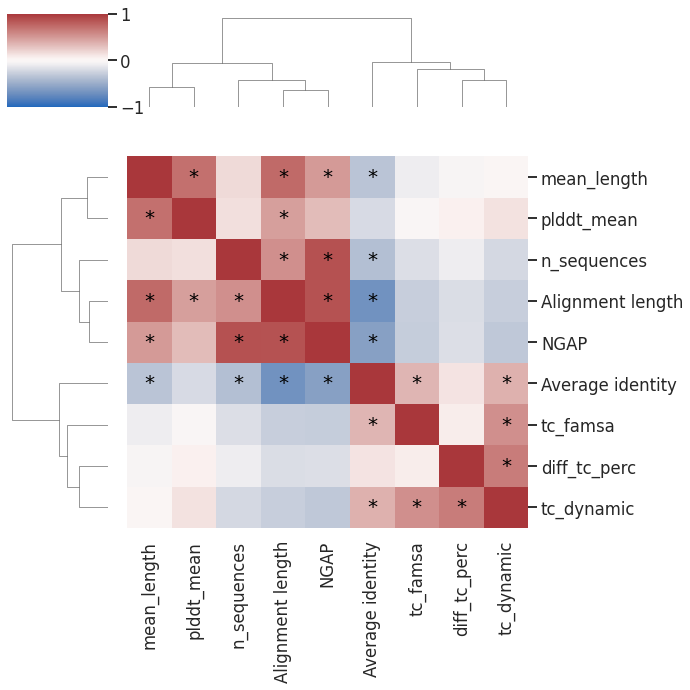

In [167]:



df_correlation = df_d_r[["diff_tc_perc_x","tc_x","tc_y",
                         "n_sequences_x",
                         "mean_length_x", "plddt_mean_x",
                         "Alignment length_x", "Average identity_x", 
                         "NGAP_x"]]
#df_d_r = df_d_r[df_d_r.n_sequences_x > 1000]
df_correlation.columns = df_correlation.columns.str.replace("tc_x","tc_dynamic")
df_correlation.columns = df_correlation.columns.str.replace("tc_y","tc_famsa")

df_correlation.columns = df_correlation.columns.str.replace("_x","")
df_correlation.columns = df_correlation.columns.str.replace("_y","_ref")


from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df_correlation)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)

# Extra plots

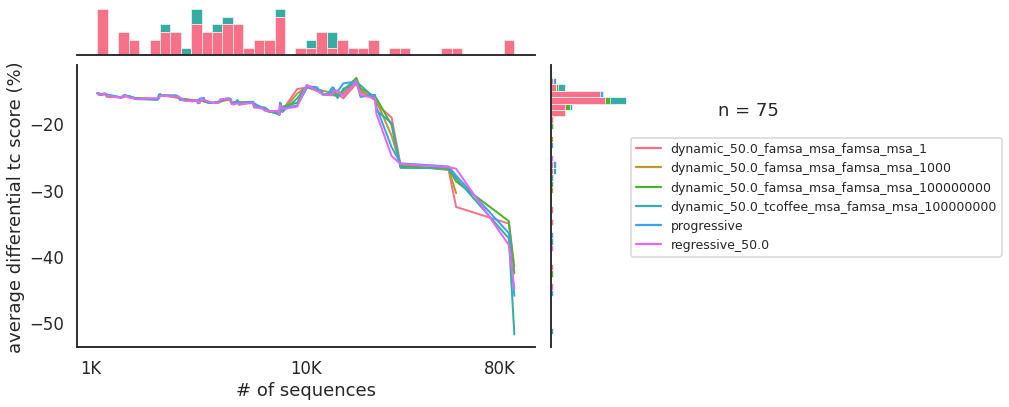

In [60]:
# --------------------------------
#         Plot TC difference
# --------------------------------
stats_alignments_regressive_50  = stats_alignments_regressive[stats_alignments_regressive.bucket_size == 50]
df = pd.concat([stats_alignments_regressive_50,stats_alignments_progressive, stats_alignments_dynamic])
#df = stats_alignments_full
df = df[df.n_sequences > 1000]
df["n_sequences"] = np.log10( df["n_sequences"] )  
fams = (df.family.unique())


x = df.n_sequences
y = cumavg(df.sort_values(by=["n_sequences"], ascending = False)["diff_tc"])
hue = df["approach"]

colors = [ "#496ADA","#A0A0A0", "#FF3F3F" ]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))



ax = sns.JointGrid(x = x, y = y, hue = hue)
ax.plot_joint(sns.lineplot,  linewidth=2)
ax.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=40)
ax.ax_joint.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=5.8, fontsize = "x-small")
ax.fig.set_figwidth(10)
ax.fig.set_figheight(6)

ax.ax_joint.set(xlabel = "# of sequences", ylabel = "average differential tc score (%)")
ax.ax_joint.set_xticks(np.log10([1000,10000,80000]))

ax.ax_joint.set_xticklabels(["1K", "10K", "80K"]) 
plt.title("n = "+str(len(fams)), x=2.5, y=0.8)


outdir = "../../../data/structural_regression/plots/03_benchmarkDynamic/" 
plt.savefig(os.path.join(outdir, "01_seq_vs_tc.pdf"))

# add more sequences: 100 

In [168]:
stats_alignments_full[stats_alignments_full.bucket_size == 100]

,index,name,sp,tc,column,Number of sequences,Alignment length,Total # residues,Smallest,Largest,...,n_sequences_ref,mean_length_ref,min_length_ref,max_length_ref,size_group_ref,perc_ref_total_ref,fam_approach_ref,diff_tc,diff_sp,diff_tc_perc


In [169]:
stats_alignments_full = get_stats(scores_df_full, traces, summary_homfam_exthomfam)


In [179]:
fam_100 = scores_df_full[(scores_df_full.method == "dynamic") & (scores_df_full.bucket_size == 100)].family.unique()

df = scores_df_full
df_dyn = df[(df.method == "dynamic") & (df.dynamicX_val == "100000000") & (df.master_msa == "tcoffee_msa")]
fams = fam_100
df_dyn = df_dyn[df_dyn.family.isin(fams)]

df_prog = df[(df.method == "progressive") & (df.family.isin(fams))]
df_reg = df[(df.method == "regressive")  & (df.bucket_size == 50) & (df.family.isin(fams))]
df = pd.concat([df_dyn, df_reg, df_prog])

df["method_expanded"] = df[["method", "bucket_size"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
df.method_expanded = df.method_expanded.str.replace("_nan", "")

In [181]:
df

,name,sp,tc,column,Number of sequences,Alignment length,Total # residues,Smallest,Largest,Average length,...,WEIGHTED_HOMOPLASY2,LEN,NGAP,NGAP2,tag,benchmarking_dataset,plddt_mean,plddt_min,plddt_max,method_expanded
633,sdr.dynamic.100.dynamicX.100000000.tcoffee_msa...,67.8,25.6,33.7,50157,6923,8188258,21,297,163.3,...,37314,6921,339048653,2982616131l,full,homfam,81.290758,58.0199,88.0147,dynamic_100.0
642,sdr.dynamic.50.dynamicX.100000000.tcoffee_msa....,69.7,26.5,35.0,50157,6250,8188258,21,297,163.3,...,43305,6248,305292992,3714223758l,full,homfam,81.290758,58.0199,88.0147,dynamic_50.0
794,Acetyltransf.dynamic.100.dynamicX.100000000.tc...,72.7,31.2,36.5,46285,6268,3841179,28,181,83.0,...,76579,6266,286273201,1615310411l,full,homfam,78.603788,60.7213,86.1721,dynamic_100.0
798,Acetyltransf.dynamic.50.dynamicX.100000000.tco...,70.8,27.5,31.1,46285,5196,3841179,28,181,83.0,...,67320,5194,236655681,1054305959l,full,homfam,78.603788,60.7213,86.1721,dynamic_50.0
1016,rvp.dynamic.50.dynamicX.100000000.tcoffee_msa....,44.3,18.0,20.3,93681,660,8833046,22,133,94.3,...,565,658,52996414,1460249206l,full,homfam,77.074836,34.1170,84.4000,dynamic_50.0
1019,rvp.dynamic.100.dynamicX.100000000.tcoffee_msa...,39.7,18.0,20.3,93681,637,8833046,22,133,94.3,...,772,635,50841751,897957089l,full,homfam,77.074836,34.1170,84.4000,dynamic_100.0
630,sdr.regressive.50.FAMSA.FAMSA-medoid,57.8,16.4,22.4,50157,29464,8188258,21,297,163.3,...,76658,29462,1469637590,3634505752l,full,homfam,81.290758,58.0199,88.0147,regressive_50.0
788,Acetyltransf.regressive.50.FAMSA.FAMSA-medoid,36.8,2.1,2.4,46285,25710,3841179,28,181,83.0,...,79759,25708,1186146171,1794293535l,full,homfam,78.603788,60.7213,86.1721,regressive_50.0
1006,rvp.regressive.50.FAMSA.FAMSA-medoid,33.6,14.4,16.2,93681,1590,8833046,22,133,94.3,...,1716,1588,140119744,1350610526l,full,homfam,77.074836,34.1170,84.4000,regressive_50.0
632,sdr.progressive.FAMSA.FAMSA-medoid,50.4,4.1,4.3,50157,6238,8188258,21,297,163.3,...,NaN,NaN,NaN,NaN,full,homfam,81.290758,58.0199,88.0147,progressive


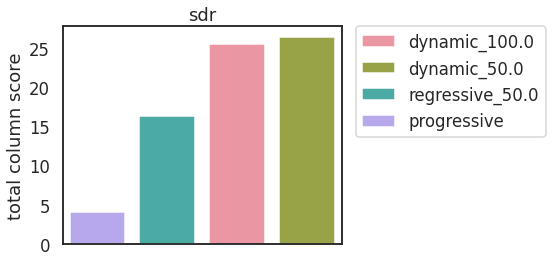

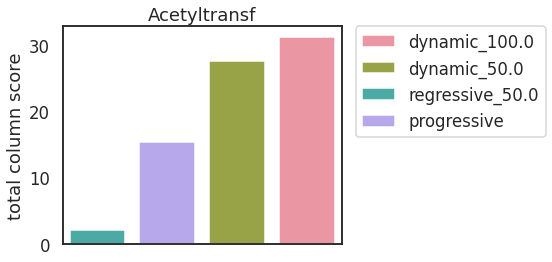

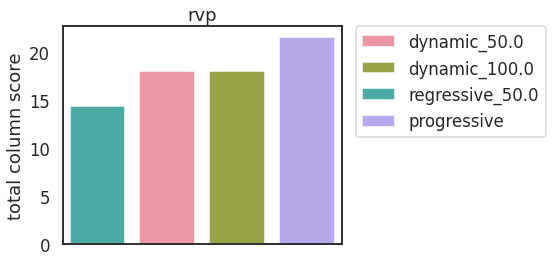

In [182]:
for family in fam_100: 
    df_plot = df[df.family == family]
    f, ax = plt.subplots(figsize=(5, 4))
    ax=sns.barplot(x="name", y="tc", data=df_plot, hue="method_expanded", order=df_plot.sort_values('tc').name, dodge = False)
    ax.set(xticklabels="", xlabel = "", ylabel = "total column score", title = family)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [185]:
stats_alignments_full[stats_alignments_full.family == "rvp"].n_sequences

502    93681
503    93681
504    93681
505    93681
506    93681
507    93681
508    93681
509    93681
Name: n_sequences, dtype: int64